### Just a space to run code while linux computer is busy

In [1]:
#Load all my packages
import pandas as pd
import numpy as np
import sklearn
import sklearn.ensemble
from scipy import sparse
import matplotlib.pyplot as plt
import torch
import tensorflow as tf

from sklearn.preprocessing import scale
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets  import make_multilabel_classification 
from sklearn.multiclass  import OneVsRestClassifier
from skmultilearn.model_selection import IterativeStratification
from sklearn.svm  import SVC 
from sklearn.decomposition  import PCA 
from sklearn.cross_decomposition  import CCA 
from fastai.metrics import accuracy_thresh
from fastai.metrics import fbeta
from torch import from_numpy

from sklearn.metrics import roc_auc_score
from sklearn.metrics import average_precision_score
from sklearn.metrics import fbeta_score
from sklearn.metrics import accuracy_score
from fastai.torch_core import np2model_tensor
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

C:\Users\jmcketney.AD\AppData\Local\Continuum\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\jmcketney.AD\AppData\Local\Continuum\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\jmcketney.AD\AppData\Local\Continuum\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\jmck

In [2]:
#Defining the function for adding the pyteomic pieces
from pyteomics import mass
from pyteomics import parser
from pyteomics import electrochem


def addfeatures(featurestable, seqlabel = 'Sequence'):
    Mass = list()
    pI = list()
    Charge = list()
    
    for i in range(0, featurestable.shape[0]):
        ps = parser.parse(featurestable[seqlabel][i], show_unmodified_termini=True)
        
        Mass.append(mass.calculate_mass(parsed_sequence=ps))
        Charge.append(electrochem.charge(ps, 2.5))
        pI.append(electrochem.pI(featurestable[seqlabel][i]))
        
    
    featurestable['pyMass'] = Mass
    featurestable['pI'] = pI
    featurestable['pyCharge'] = Charge
    
    return(featurestable)



#WANT TO TRY ONE-HOT WITH LIST THAT I THEN CONVERT INTO FRAME AFTERWARD
#WOULD ALSO ALLOW FOR THE USE OF THE KARAS PADDING FUNCTION SO THAT I CAN HIT THEM ALL WITH ZEROS AT THE SAME TIME
import numpy as np
from numpy import array
from numpy import argmax         #finds the index of the maximum value in a vector
from keras.utils import to_categorical
from keras_preprocessing.sequence import pad_sequences

def simpleOneHot(data_frame, sequenceTag = 'ModSequence', alphabet = 'ACDEFGHIKLMNPQRSTVWY'):
    #Start by finding the max and calculating needed vector length
    VEC_LENGTH = max(data_frame['Length']) * len(alphabet)
    
    #Define what residues are possible
    AMINO_ACIDS = alphabet 
    
    #TURNING CHARACTERS INTO INTEGERS
    # Map character keys to integer values in a dictionary, then map integer keys to character values to revers transform
    char_to_int = dict((c, i) for i, c in enumerate(AMINO_ACIDS))   #character keys to integer values
    int_to_char = dict((i, c) for i, c in enumerate(AMINO_ACIDS))   #integer keys to character values
    
    
    hotlist = list()
    #Build out the rest of the sequences' one-hot arrays
    
    for i in range(0, data_frame.shape[0]):
        
        pep = data_frame[sequenceTag][i]
        #print(pep)
        integer_encode = [char_to_int[char] for char in pep]
        encoded = to_categorical(integer_encode, num_classes=22)
        flatencode = encoded.flatten()
        
        #numzeros = VEC_LENGTH - len(flatencode)
        #flatencode = np.append(flatencode, [[0] * numzeros])
        
        hotlist.append(flatencode)
    
    padded = pad_sequences(hotlist, padding= 'post', maxlen=VEC_LENGTH)
    
    hotarray = np.array(padded)
    
    hotarray.shape
    return(hotarray)

Using TensorFlow backend.


In [44]:
#data_df = pd.read_csv("ThresholdReportAllContinuous.csv", low_memory=False)  #read in dynamic threshold only continuous labels
#data_df = pd.read_csv("ThresholdedRandomEvenSampling.csv", low_memory=False)  #read in dynamic threshold only continuous labels
#data_df = pd.read_csv("LimitingLabelCounts.csv", low_memory=False)  #Label limited with second iteration
#data_df = pd.read_csv("NewJGMDataWFeatures.csv", low_memory=False) #Read in second JGM Dataset
#data_df = pd.read_csv("DynThresh50percentContinuousJGMData.csv", low_memory=False) #read in 50% dynamic threshold
#data_df = pd.read_csv("AnyIntensityThreshold.csv", low_memory=False) #read in static >0 threshold data set
#data_df = pd.read_csv("AnyIntensityThresholdAllContinuous.csv", low_memory=False) #read in static > 0 threshold, only continous
#data_df = pd.read_csv("MixModeThresholdAllContinuous.csv", low_memory=False) #read in combo threshold with 50% proportiona and static thrsh 
data_df = pd.read_csv("50percentMaxPlusThreshold.csv", low_memory=False) #read in data for target prediction


#Then lets add the pyteomic features always same function 
data_df = addfeatures(data_df)

#And add one-hot array
#For JGM data, different alphabet
data_hotarray = simpleOneHot(data_frame=data_df, alphabet='ACDEFGHIKLMNPQRSTVWYam')

#For MQ data, just standard alphabet
#data_hotarray = simpleOneHot(data_frame=MQ_df, sequenceTag='Sequence', alphabet='ACDEFGHIKLMNPQRSTVWY')

In [45]:
from sklearn.preprocessing import scale
#SCALED NON ONE HOT FEATURES
#Select the features we actually want to use besides the one-hot array
feature_subset = ['Charge', 'Length', 'pyMass', 'pI']#, 'pyCharge']
#feature_subset = ['Charge', 'Length','R.Norm', 'N.Norm', 'D.Norm', 'C.Norm', 'Q.Norm', 'E.Norm', 'G.Norm',
#       'H.Norm', 'I.Norm', 'L.Norm', 'K.Norm', 'M.Norm', 'F.Norm', 'S.Norm',
#       'T.Norm', 'W.Norm', 'Y.Norm', 'V.Norm']
#Normalized aa counts available for MQ data

#assign those features to X, if using one-hot than will make array
#X = np.concatenate((scale(data_df[feature_subset]), data_hotarray), axis = 1)
X = np.concatenate((data_df[feature_subset], data_hotarray), axis = 1)
#X = data_df[feature_subset]   #IF DON'T WANT TO USE ONE-HOT ARRAY AS FEATURE
#X = data_df.loc[0:5000, 'Charge']

#Selecting labels to be used as y. Again the "values" att makes the output an array
y = data_df.loc[ : ,  'X20':'X95'].values

#Need different index for MQ data
#y = data_df.loc[:, 'CV20':'CV95'].values

In [18]:
X.shape


(101567, 1104)

In [ ]:
from sklearn.decomposition import PCA
# reduce dimensionality or normalized AA counts with PCA
pca = PCA(n_components=400)                    #defining pca method parameters. Need 182 to get to 70% variance
decomposed_1hot = pca.fit_transform(hotarray)
pca.fit_transform(hotarray)
type(pca)

In [ ]:
print(pca.explained_variance_ratio_.cumsum())

In [36]:
#Train test split to just make it faster and in interest of train-test-validate system
#Will do it iteratively though. NOTE: iterative_train_test_split can only take in array, not data frame
from skmultilearn.model_selection import  iterative_train_test_split

X1, y1, X2, y2 = iterative_train_test_split(X, y, test_size=0.20)


In [37]:
multiforest = OneVsRestClassifier(RandomForestClassifier(n_estimators = 200, random_state=23), n_jobs=2)#, class_weight='balanced'))
#multiforest.fit(X_train, y_train)
#y_fpredict = multiforest.predict(X_test)
#y_probs = multiforest.predict_proba(X_test)

#print(accuracy_thresh(torch.from_numpy(y_probs), y_test, thresh=0.7, sigmoid=False))

#scaled_X = scale(X1)

bthacc7 = []
bthacc5 = []
bprec = []
broc = []
brecall = []

k_fold = IterativeStratification(n_splits=5, order=4)#, random_state=123)
for train, test in k_fold.split(X1, y1):
        
        #Train the multiforest using the training indices
        multiforest.fit(X1[train], y1[train])
        
        #Generate predictions
        y_predict = multiforest.predict(X1[test])
        y_predprobs = multiforest.predict_proba(X1[test])
        
        #Gotta convert both of them to tensors hahahaha
        bthacc7.append(accuracy_thresh(np2model_tensor(y_predprobs), np2model_tensor(y1[test]), thresh=0.7, sigmoid=False))
        bthacc5. append(accuracy_thresh(np2model_tensor(y_predprobs), np2model_tensor(y1[test]), thresh=0.5, sigmoid=False))
        bprec.append(average_precision_score( y1[test], y_predict, average='weighted'))
        broc.append(roc_auc_score( y1[test], y_predprobs, average='weighted'))
        brecall.append(recall_score( y1[test], y_predict, average='weighted'))
        

### Multilabel RFC without OneVsRest

In [46]:
#Running multiforest without OneVsRest wrapper
multiforest = RandomForestClassifier(n_estimators = 200, random_state=23)#, class_weight='balanced'))

bthacc7 = []
bthacc5 = []
bprec = []
broc = []
brecall = []

k_fold = IterativeStratification(n_splits=5, order=4)#, random_state=123)
for train, test in k_fold.split(X1, y1):
        
        #Train the multiforest using the training indices
        multiforest.fit(X1[train], y1[train])
        
        #Generate predictions
        y_predict = multiforest.predict(X1[test])
        y_problist = multiforest.predict_proba(X1[test])
        
        y_predprobs = np.array([[]] *X1[test].shape[0])
        for item in y_problist:
            y_predprobs = np.concatenate((y_predprobs, np.reshape(item[:, 1], (-1, 1))), axis = 1)

            
        
        #Gotta convert both of them to tensors hahahaha
        bthacc7.append(accuracy_thresh(np2model_tensor(y_predprobs), np2model_tensor(y1[test]), thresh=0.7, sigmoid=False))
        bthacc5. append(accuracy_thresh(np2model_tensor(y_predprobs), np2model_tensor(y1[test]), thresh=0.5, sigmoid=False))
        bprec.append(average_precision_score( y1[test], y_predict, average='weighted'))
        broc.append(roc_auc_score( y1[test], y_predprobs, average='weighted'))
        brecall.append(recall_score( y1[test], y_predict, average='weighted'))
        

In [38]:
#Mixed Mode threshold
print("Recall:  \n", np.mean(brecall))
print("Precision:  \n", np.mean(bprec))
print("ROCAUC:  \n", np.mean(broc))
print("Threshold Accuracy:  \n", np.mean(bthacc5))

Recall:  
 0.4891696644645611
Precision:  
 0.4801360392865387
ROCAUC:  
 0.8426170260621959
Threshold Accuracy:  
 0.85394925


In [21]:
#Most liberal label assignment dataset  any intensity > 0, continous only
print("Recall:  \n", np.mean(brecall))
print("Precision:  \n", np.mean(bprec))
print("ROCAUC:  \n", np.mean(broc))
print("Threshold Accuracy:  \n", np.mean(bthacc5))

Recall:  
 0.5112746552656112
Precision:  
 0.5008871607387166
ROCAUC:  
 0.8461252742475986
Threshold Accuracy:  
 0.8459856


In [13]:
#Most liberal label assignment dataset  any intensity > 0, discontinuous
print("Recall:  \n", np.mean(brecall))
print("Precision:  \n", np.mean(bprec))
print("ROCAUC:  \n", np.mean(broc))
print("Threshold Accuracy:  \n", np.mean(bthacc5))

Recall:  
 0.49790255223625823
Precision:  
 0.48889666348606403
ROCAUC:  
 0.8225078547432855
Threshold Accuracy:  
 0.8251936


In [47]:
#Trying out the non-OVR multiforest 50% median proportional threshold, all continuous
print("Recall:  \n", np.mean(brecall))
print("Precision:  \n", np.mean(bprec))
print("ROCAUC:  \n", np.mean(broc))
print("Threshold Accuracy:  \n", np.mean(bthacc5))

Recall:  
 0.3608852657553997
Precision:  
 0.39298243331441457
ROCAUC:  
 0.848066221932308
Threshold Accuracy:  
 0.86191213


In [45]:
#Weighted 50% proportional dynamic threshold, all continuous
print("Recall:  \n", np.mean(brecall))
print("Precision:  \n", np.mean(bprec))
print("ROCAUC:  \n", np.mean(broc))
print("Threshold Accuracy:  \n", np.mean(bthacc5))

Recall:  
 0.35985376551830395
Precision:  
 0.3885077895130372
ROCAUC:  
 0.840183994177468
Threshold Accuracy:  
 0.8602955


In [40]:
#Weighted 50% proportional dynamic threshold
print("Recall:  \n", np.mean(brecall))
print("Precision:  \n", np.mean(bprec))
print("ROCAUC:  \n", np.mean(broc))
print("Threshold Accuracy:  \n", np.mean(bthacc5))

Recall:  
 0.3426146128861155
Precision:  
 0.3770215458640528
ROCAUC:  
 0.8317985250706521
Threshold Accuracy:  
 0.852993


In [37]:
#Macro 50% proportional dynamic threshold
print("Recall:  \n", np.mean(brecall))
print("Precision:  \n", np.mean(bprec))
print("ROCAUC:  \n", np.mean(broc))
print("Threshold Accuracy:  \n", np.mean(bthacc5))

Recall:  
 0.2823234414270637
Precision:  
 0.3113822179940469
ROCAUC:  
 0.851138203130487
Threshold Accuracy:  
 0.85293496


In [39]:
#5 fold split that just collects metrics from each split
#Defined above
#So could actually make this even more flexible
from skmultilearn.model_selection import IterativeStratification
from sklearn.metrics import precision_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import recall_score


#instantiate the forest and fit it to the subset
multiforest = OneVsRestClassifier(RandomForestClassifier(n_estimators = 200, random_state=23), n_jobs = 2)

i = 0

metricdict = dict()

#Iterative stratification doesn't actually need a random state because I haven't set shuffle =True
k_fold = IterativeStratification(n_splits=5, order=2)#, random_state=123)
for train, test in k_fold.split(X1, y1):
    i = i + 1
    #Make dictionary to hold metric arrays
    kfold = dict()
    
    #Train the multiforest using the training indices
    multiforest.fit(X1[train], y1[train])
    
    #Generate predictions
    y_predict = multiforest.predict(X1[test])
    y_predprobs = multiforest.predict_proba(X1[test])
    #Add metric arrays to dictionary keys
    metricdict[('precision_kfold_' + str(i))] = precision_score(y1[test], y_predict, average=None)
    metricdict[('recall_kfold_' + str(i))] = recall_score(y1[test], y_predict, average=None)
    metricdict[('rocScore_kfold_' + str(i))] = roc_auc_score(y1[test], y_predprobs, average=None)
    metricdict[('accuracy_kfold_' + str(i))] = np.sum(abs(y1[test] - y_predict), axis = 0) / y1[test].shape[0]
    metricdict[('realCount_kfold_' + str(i))] = np.sum(y1[test], axis = 0)
    metricdict[('predictCount_kfold_' + str(i))] = np.sum(y_predict, axis = 0)
    
    

In [17]:
#small_random_metric_df = np.transpose(pd.DataFrame(metricdict))
#small_random_metric_df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
precision_kfold_1,0.827957,0.846154,0.675926,0.333333,0.000000,0.000000,0.000000,0.000000,0.000000,0.333333,0.714286,0.607843,0.712230,0.760684,0.796296,0.900000
recall_kfold_1,0.810526,0.739496,0.536765,0.010638,0.000000,0.000000,0.000000,0.000000,0.000000,0.007407,0.033333,0.164894,0.473684,0.458763,0.267081,0.078947
rocScore_kfold_1,0.973600,0.957308,0.916437,0.889862,0.873437,0.765557,0.737017,0.747444,0.680857,0.725964,0.759628,0.807859,0.862985,0.868844,0.884546,0.879685
accuracy_kfold_1,0.047026,0.065007,0.135546,0.131397,0.087137,0.074689,0.106501,0.127248,0.159059,0.188105,0.203320,0.244813,0.207469,0.183956,0.178423,0.146611
realCount_kfold_1,95.000000,119.000000,136.000000,94.000000,63.000000,54.000000,74.000000,91.000000,113.000000,135.000000,150.000000,188.000000,209.000000,194.000000,161.000000,114.000000
predictCount_kfold_1,93.000000,104.000000,108.000000,3.000000,0.000000,0.000000,3.000000,1.000000,2.000000,3.000000,7.000000,51.000000,139.000000,117.000000,54.000000,10.000000
precision_kfold_2,0.904110,0.873563,0.719512,0.000000,0.000000,0.000000,0.000000,0.500000,0.000000,0.600000,0.500000,0.589286,0.682432,0.704545,0.734375,0.600000
recall_kfold_2,0.694737,0.644068,0.433824,0.000000,0.000000,0.000000,0.000000,0.010989,0.000000,0.022222,0.026144,0.174603,0.483254,0.476923,0.290123,0.052632
rocScore_kfold_2,0.981106,0.962086,0.926489,0.899799,0.859669,0.791378,0.704797,0.770230,0.732049,0.753554,0.758249,0.806864,0.857803,0.877346,0.886739,0.844773
accuracy_kfold_2,0.049383,0.072702,0.137174,0.130316,0.086420,0.074074,0.101509,0.124829,0.155007,0.183813,0.209877,0.245542,0.212620,0.193416,0.181070,0.153635


In [47]:
small_random_metric_df['Analysis'] = ['small random'] * small_random_metric_df.shape[0]

In [20]:
np.sum(data_df.loc[ : ,  'X20':'X95'].values, axis = 0) #/ y.shape[0]

array([ 593,  764,  853,  587,  395,  334,  461,  570,  708,  846,  932, 1181, 1313, 1242, 1020,  712], dtype=int64)

In [25]:
#labelnumbercap_metric_df = np.transpose(pd.DataFrame(metricdict))
#labelnumbercap_metric_df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
precision_kfold_1,0.881988,0.932161,0.789091,0.315789,0.394231,0.390244,0.368794,0.171875,0.358209,0.320000,0.333333,0.269231,0.535714,0.666667,0.692308,0.625000
recall_kfold_1,0.618736,0.708015,0.410208,0.014388,0.037443,0.038772,0.044255,0.015007,0.029268,0.023845,0.022449,0.016588,0.038961,0.048611,0.049724,0.042017
rocScore_kfold_1,0.976716,0.979133,0.938930,0.797502,0.750113,0.670650,0.665718,0.673067,0.751746,0.765833,0.817402,0.841002,0.882547,0.900863,0.889950,0.879331
accuracy_kfold_1,0.030560,0.025825,0.053085,0.060832,0.160258,0.181492,0.173888,0.111191,0.120373,0.098852,0.071879,0.062267,0.054950,0.040316,0.025251,0.016786
realCount_kfold_1,459.000000,524.000000,529.000000,417.000000,1095.000000,1238.000000,1175.000000,733.000000,820.000000,671.000000,490.000000,422.000000,385.000000,288.000000,181.000000,119.000000
predictCount_kfold_1,322.000000,398.000000,275.000000,19.000000,104.000000,123.000000,141.000000,64.000000,67.000000,50.000000,33.000000,26.000000,28.000000,21.000000,13.000000,8.000000
precision_kfold_2,0.865103,0.915000,0.845850,0.277778,0.389381,0.415493,0.372671,0.210526,0.295775,0.260870,0.291667,0.280000,0.400000,0.727273,0.416667,0.375000
recall_kfold_2,0.641304,0.697143,0.404537,0.012019,0.040183,0.047696,0.051064,0.016349,0.025610,0.017857,0.014257,0.016588,0.025974,0.055749,0.027624,0.025424
rocScore_kfold_2,0.982851,0.978738,0.952097,0.777403,0.741025,0.674510,0.647403,0.678279,0.743603,0.770307,0.796626,0.825002,0.877316,0.871377,0.902511,0.898383
accuracy_kfold_2,0.030268,0.027686,0.050782,0.060823,0.160666,0.180892,0.174437,0.110027,0.121790,0.099555,0.071869,0.062114,0.055946,0.039736,0.026252,0.017214


In [48]:
labelnumbercap_metric_df['Analysis'] = ['label number cap'] * labelnumbercap_metric_df.shape[0]

In [31]:
#Dynamic thresholded by median intensity, non continuous removed
threshold_metrics_df = np.transpose(pd.DataFrame(metricdict))
threshold_metrics_df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
precision_kfold_1,0.771704,0.842986,0.812160,0.737348,0.608586,0.398374,0.419274,0.519828,0.506803,0.542725,0.575456,0.585185,0.562249,0.552448,0.426471,0.282051
recall_kfold_1,0.292683,0.639024,0.685020,0.510421,0.235352,0.066917,0.090394,0.145406,0.150353,0.135877,0.118027,0.103313,0.086154,0.074669,0.047697,0.035948
rocScore_kfold_1,0.964773,0.956136,0.936256,0.874833,0.812353,0.743883,0.735949,0.768834,0.802462,0.839295,0.867734,0.881210,0.884704,0.889110,0.901720,0.900852
accuracy_kfold_1,0.034152,0.051621,0.092016,0.158850,0.196831,0.158903,0.201186,0.215140,0.207114,0.177578,0.149460,0.116724,0.083622,0.054716,0.032421,0.016945
realCount_kfold_1,820.000000,2050.000000,3705.000000,4510.000000,4096.000000,2929.000000,3706.000000,4147.000000,3964.000000,3459.000000,2940.000000,2294.000000,1625.000000,1058.000000,608.000000,306.000000
predictCount_kfold_1,311.000000,1554.000000,3125.000000,3122.000000,1584.000000,492.000000,799.000000,1160.000000,1176.000000,866.000000,603.000000,405.000000,249.000000,143.000000,68.000000,39.000000
precision_kfold_2,0.819936,0.855495,0.809618,0.729797,0.599130,0.414687,0.397359,0.504910,0.503100,0.511278,0.561576,0.584112,0.591912,0.552795,0.452055,0.343750
recall_kfold_2,0.310976,0.614822,0.663428,0.518625,0.235352,0.065551,0.089291,0.148782,0.143290,0.117953,0.116366,0.108980,0.099077,0.084121,0.052464,0.036066
rocScore_kfold_2,0.962470,0.954419,0.931591,0.875787,0.804768,0.741209,0.728330,0.771223,0.794287,0.831907,0.869203,0.878626,0.892682,0.903449,0.902119,0.905270
accuracy_kfold_2,0.032547,0.052568,0.095650,0.159172,0.197956,0.157652,0.203249,0.216719,0.207390,0.180346,0.150105,0.116457,0.082547,0.054560,0.033333,0.016509


In [8]:
#Dynamic thresholded by median intensity 50%, non continuous removed
#threshold50p_metrics_df = np.transpose(pd.DataFrame(metricdict))
#threshold50p_metrics_df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
precision_kfold_1,0.764045,0.842703,0.825995,0.739386,0.673684,0.629281,0.606665,0.593997,0.559094,0.580899,0.574503,0.577215,0.538153,0.496403,0.483871,0.419355
recall_kfold_1,0.288136,0.621526,0.677300,0.621960,0.515406,0.395374,0.355215,0.294902,0.207500,0.143571,0.116560,0.099087,0.082360,0.065652,0.049020,0.042208
rocScore_kfold_1,0.960211,0.948306,0.928030,0.875945,0.814299,0.774119,0.766362,0.794459,0.807318,0.841539,0.869358,0.885205,0.892353,0.893879,0.901516,0.896860
accuracy_kfold_1,0.040560,0.060143,0.100971,0.168679,0.225012,0.250604,0.257471,0.248082,0.225710,0.185471,0.154890,0.120178,0.086271,0.056441,0.032942,0.016793
realCount_kfold_1,944.000000,2267.000000,4044.000000,5264.000000,5712.000000,5577.000000,5484.000000,5100.000000,4400.000000,3601.000000,2977.000000,2301.000000,1627.000000,1051.000000,612.000000,308.000000
predictCount_kfold_1,356.000000,1672.000000,3316.000000,4428.000000,4370.000000,3504.000000,3211.000000,2532.000000,1633.000000,890.000000,604.000000,395.000000,249.000000,139.000000,62.000000,31.000000
precision_kfold_2,0.768546,0.830489,0.824186,0.748571,0.680074,0.616233,0.592661,0.600078,0.554493,0.579429,0.602369,0.622685,0.615385,0.601307,0.546667,0.343750
recall_kfold_2,0.274364,0.643739,0.694362,0.622032,0.511990,0.390712,0.353456,0.302216,0.197727,0.140833,0.119583,0.115699,0.098341,0.087536,0.067434,0.035599
rocScore_kfold_2,0.961874,0.951757,0.931761,0.882484,0.819973,0.772229,0.766034,0.794100,0.808856,0.840379,0.869875,0.882259,0.888263,0.896851,0.903893,0.903724
accuracy_kfold_2,0.040885,0.059265,0.098328,0.165577,0.223127,0.254796,0.261333,0.245686,0.226610,0.185457,0.153038,0.118905,0.083967,0.054657,0.032204,0.017094


In [23]:
#Static greater than zero intensity threshold, all continuous
#anyintensity_metrics_df = np.transpose(pd.DataFrame(metricdict))
anyintensity_metrics_df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
precision_kfold_1,0.742690,0.812288,0.811523,0.770130,0.739621,0.702652,0.666087,0.645473,0.633572,0.620755,0.647059,0.634021,0.635071,0.625954,0.596774,0.535714
recall_kfold_1,0.305533,0.626726,0.719325,0.719638,0.705923,0.672725,0.592512,0.470344,0.331426,0.189680,0.155258,0.113416,0.087070,0.080629,0.064348,0.051903
rocScore_kfold_1,0.922111,0.930183,0.917246,0.872992,0.822699,0.794601,0.789976,0.810467,0.825525,0.844708,0.870956,0.885811,0.893816,0.905705,0.904170,0.897481
accuracy_kfold_1,0.061393,0.085384,0.127276,0.195128,0.241757,0.271346,0.280143,0.268885,0.240465,0.197650,0.162032,0.127030,0.091166,0.060531,0.034633,0.017655
realCount_kfold_1,1247.000000,2679.000000,4621.000000,6406.000000,7243.000000,7208.000000,6464.000000,5547.000000,4544.000000,3469.000000,2834.000000,2169.000000,1539.000000,1017.000000,575.000000,289.000000
predictCount_kfold_1,513.000000,2067.000000,4096.000000,5986.000000,6913.000000,6901.000000,5750.000000,4042.000000,2377.000000,1060.000000,680.000000,388.000000,211.000000,131.000000,62.000000,28.000000
precision_kfold_2,0.748201,0.818408,0.808925,0.768249,0.738939,0.696892,0.660882,0.651067,0.628727,0.618100,0.655523,0.706186,0.659193,0.594595,0.606061,0.476190
recall_kfold_2,0.333601,0.614035,0.710019,0.732636,0.694049,0.681232,0.589109,0.483958,0.329373,0.196830,0.159139,0.125573,0.096711,0.087562,0.066890,0.034602
rocScore_kfold_2,0.924238,0.930136,0.912625,0.871348,0.819478,0.791762,0.788124,0.815500,0.824755,0.852015,0.874297,0.894025,0.893784,0.897723,0.903848,0.889210
accuracy_kfold_2,0.059699,0.086013,0.130034,0.192376,0.245435,0.272610,0.283431,0.264494,0.241746,0.197295,0.161082,0.124316,0.089087,0.060068,0.035905,0.017830


In [40]:
#Combining edge cutoff with any intensity middle, all continuous
mixedthresh_metrics_df = np.transpose(pd.DataFrame(metricdict))
mixedthresh_metrics_df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
precision_kfold_1,0.762712,0.844610,0.812685,0.748709,0.737525,0.703887,0.673339,0.660547,0.627772,0.625905,0.631367,0.598063,0.607595,0.543046,0.539474,0.375000
recall_kfold_1,0.200000,0.650630,0.684688,0.540373,0.690521,0.695067,0.627148,0.524318,0.358373,0.212743,0.159014,0.109583,0.091545,0.079922,0.069257,0.044118
rocScore_kfold_1,0.968211,0.958130,0.935129,0.880205,0.819733,0.797203,0.793618,0.815184,0.822094,0.849650,0.873042,0.889995,0.900013,0.900215,0.907716,0.911544
accuracy_kfold_1,0.034750,0.048901,0.090399,0.154048,0.245522,0.270420,0.277585,0.262539,0.245761,0.199666,0.165154,0.129747,0.090877,0.060485,0.034989,0.016718
realCount_kfold_1,675.000000,1746.000000,3200.000000,4025.000000,7406.000000,7582.000000,6866.000000,5901.000000,4819.000000,3657.000000,2962.000000,2254.000000,1573.000000,1026.000000,592.000000,272.000000
predictCount_kfold_1,177.000000,1345.000000,2696.000000,2905.000000,6934.000000,7487.000000,6395.000000,4684.000000,2751.000000,1243.000000,746.000000,413.000000,237.000000,151.000000,76.000000,32.000000
precision_kfold_2,0.799065,0.851080,0.814658,0.737462,0.741682,0.706330,0.672724,0.653829,0.646662,0.621689,0.658762,0.622378,0.607930,0.543624,0.447368,0.392857
recall_kfold_2,0.253333,0.631730,0.663230,0.544213,0.713244,0.697573,0.625492,0.503474,0.357751,0.205360,0.168805,0.118456,0.086520,0.078717,0.057530,0.039427
rocScore_kfold_2,0.962687,0.955885,0.929956,0.880159,0.827418,0.795835,0.795247,0.807499,0.825641,0.848021,0.876566,0.892200,0.902444,0.908876,0.911069,0.884585
accuracy_kfold_2,0.032614,0.049845,0.093072,0.155915,0.236346,0.267827,0.277844,0.268483,0.240699,0.200513,0.162235,0.128130,0.092177,0.060577,0.035714,0.016993


In [50]:
threshold_metrics_df['Analysis'] = ['threshold continuous'] * threshold_metrics_df.shape[0]

In [53]:
#So the problem is related to the accuracy
masterframe = pd.DataFrame()
masterframe.append(small_random_metric_df) #, labelnumbercap_metric_df, threshold_metrics_df)
masterframe.append(labelnumbercap_metric_df)
masterframe.append(threshold_metrics_df)

#for key in featuredict.keys():
#    metricdict = StratifiedCVMetrics(X1, y1, featuredict[str(key)])
#    metric_df = pd.DataFrame(metricdict)
#    metric_df = pd.DataFrame.transpose(metric_df)
#    featlist = [str(key)] * 30
#    metric_df['Features'] = featlist
#    masterframe = masterframe.append(metric_df)


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,Analysis
precision_kfold_1,0.771704,0.842986,0.812160,0.737348,0.608586,0.398374,0.419274,0.519828,0.506803,0.542725,0.575456,0.585185,0.562249,0.552448,0.426471,0.282051,threshold continuous
recall_kfold_1,0.292683,0.639024,0.685020,0.510421,0.235352,0.066917,0.090394,0.145406,0.150353,0.135877,0.118027,0.103313,0.086154,0.074669,0.047697,0.035948,threshold continuous
rocScore_kfold_1,0.964773,0.956136,0.936256,0.874833,0.812353,0.743883,0.735949,0.768834,0.802462,0.839295,0.867734,0.881210,0.884704,0.889110,0.901720,0.900852,threshold continuous
accuracy_kfold_1,0.034152,0.051621,0.092016,0.158850,0.196831,0.158903,0.201186,0.215140,0.207114,0.177578,0.149460,0.116724,0.083622,0.054716,0.032421,0.016945,threshold continuous
realCount_kfold_1,820.000000,2050.000000,3705.000000,4510.000000,4096.000000,2929.000000,3706.000000,4147.000000,3964.000000,3459.000000,2940.000000,2294.000000,1625.000000,1058.000000,608.000000,306.000000,threshold continuous
predictCount_kfold_1,311.000000,1554.000000,3125.000000,3122.000000,1584.000000,492.000000,799.000000,1160.000000,1176.000000,866.000000,603.000000,405.000000,249.000000,143.000000,68.000000,39.000000,threshold continuous
precision_kfold_2,0.819936,0.855495,0.809618,0.729797,0.599130,0.414687,0.397359,0.504910,0.503100,0.511278,0.561576,0.584112,0.591912,0.552795,0.452055,0.343750,threshold continuous
recall_kfold_2,0.310976,0.614822,0.663428,0.518625,0.235352,0.065551,0.089291,0.148782,0.143290,0.117953,0.116366,0.108980,0.099077,0.084121,0.052464,0.036066,threshold continuous
rocScore_kfold_2,0.962470,0.954419,0.931591,0.875787,0.804768,0.741209,0.728330,0.771223,0.794287,0.831907,0.869203,0.878626,0.892682,0.903449,0.902119,0.905270,threshold continuous
accuracy_kfold_2,0.032547,0.052568,0.095650,0.159172,0.197956,0.157652,0.203249,0.216719,0.207390,0.180346,0.150105,0.116457,0.082547,0.054560,0.033333,0.016509,threshold continuous


In [54]:
masterframe.to_csv("DifferentSamplingStrategyMetrics.csv")

## Spot Checking the RFC

In [41]:
#Make unique keys
keys = np.transpose(np.array([range(0, data_df.shape[0])]))
keys

array([[     0],
       [     1],
       [     2],
       [     3],
       ...,
       [104816],
       [104817],
       [104818],
       [104819]])

In [42]:
#Attach the keys to the feature array
X_keys = np.concatenate((keys, X), axis=1)
print(X_keys.shape)
print(X.shape)

(104820, 1105)
(104820, 1104)


In [43]:
#Train test split to just make it faster and in interest of train-test-validate system
#Will do it iteratively though. NOTE: iterative_train_test_split can only take in array, not data frame

from skmultilearn.model_selection import  iterative_train_test_split

X_train, y_train, X_test, y_test = iterative_train_test_split(X_keys, y, test_size=0.20)

In [27]:
#Split again so we have values to train the model and to predict it
X_keys1, y_1, X_keys2, y_2 = iterative_train_test_split(X_train, y_train, test_size=0.30)
X_keys1.shape

(56877, 1105)

In [28]:
multiforest = OneVsRestClassifier(RandomForestClassifier(n_estimators = 200, random_state=23), n_jobs=2)#, class_weight='balanced'))

multiforest.fit(X_keys1[: , 1:], y_1)

predict_probs = multiforest.predict_proba(X_keys2[: , 1:])
predict_labels = multiforest.predict(X_keys2[: , 1:])
predict_probs.shape

(24377, 16)

In [42]:
type(predict_probs)

numpy.ndarray

In [35]:
X_keys2.shape

(27981, 1105)

In [36]:
predict_probs_full = np.concatenate((X_keys2[:, 0:1], predict_labels, predict_probs, y_2), axis=1)
predict_probs_full.shape

In [35]:
select_data_df = data_df.loc[list(predict_probs_full[:, 0]), ['SeqCharge', 'Charge', 'Sequence']]
select_data_df.shape

(27976, 3)

In [39]:
#Gotta reset index for 
select_data_df = select_data_df.reset_index(drop=True)
data_df_predictplus = pd.concat([select_data_df, pd.DataFrame(predict_probs_full)], axis=1, sort=False)
data_df_predictplus.shape

(27976, 52)

In [40]:
data_df_predictplus.iloc[0:2, 0:30]

,SeqCharge,Charge,Sequence,0,1,2,3,4,5,6,...,17,18,19,20,21,22,23,24,25,26
0,2AACLCFR,2,AACLCFR,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000,0.000,0.03,0.08,0.14,0.245,0.36,0.385,0.400,0.39
1,3SEQEDEVLLVSSSR,3,SEQEDEVLLVSSSR,2.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.005,0.005,0.12,0.18,0.11,0.145,0.14,0.250,0.445,0.44


In [41]:
data_df_predictplus.to_csv("SpotCheckingRFC.csv")

When using the any intensity threshold see a large dip in proportion of peptides that go without labels

In [33]:
print(4141/predict_labels.shape[0], "instead of ~30%. So cut it down by about half")

0.16987324116995528 instead of ~30%. So cut it down by about half


In [29]:
#Any intensity threshold
#pd.Series(np.sum(predict_labels, axis = 1)).value_counts()

3     9923
4     4424
0     4141
2     3137
1     1799
5      644
6      167
7       82
8       44
9       12
10       2
13       1
12       1
dtype: int64

In [32]:
#Median proportional 50% dynamic threshold
#predictedlabsums.value_counts()

0    9439
2    9334
3    4543
1    3985
4     462
5     141
6      54
7      14
8       3
9       1
dtype: int64

In [29]:
predictedlabsums = predictedlabsums[0]
type(predictedlabsums)

numpy.int32

### Metric Dictionary for the multilabel forest without OneVsRest

In [48]:
#5 fold split that just collects metrics from each split
#Defined above
#So could actually make this even more flexible
from skmultilearn.model_selection import IterativeStratification
from sklearn.metrics import precision_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import recall_score


#instantiate the forest and fit it to the subset
multiforest = RandomForestClassifier(n_estimators = 200, random_state=23)

i = 0

metricdict = dict()

#Iterative stratification doesn't actually need a random state because I haven't set shuffle =True
k_fold = IterativeStratification(n_splits=5, order=2)#, random_state=123)
for train, test in k_fold.split(X1, y1):
    i = i + 1
    #Make dictionary to hold metric arrays
    kfold = dict()
    
    #Train the multiforest using the training indices
    multiforest.fit(X1[train], y1[train])
    
    #Generate predictions
    y_predict = multiforest.predict(X1[test])
    y_problist = multiforest.predict_proba(X1[test])
        
    y_predprobs = np.array([[]] *X1[test].shape[0])
    for item in y_problist:
        y_predprobs = np.concatenate((y_predprobs, np.reshape(item[:, 1], (-1, 1))), axis = 1)
    
    #Add metric arrays to dictionary keys
    metricdict[('precision_kfold_' + str(i))] = precision_score(y1[test], y_predict, average=None)
    metricdict[('recall_kfold_' + str(i))] = recall_score(y1[test], y_predict, average=None)
    metricdict[('rocScore_kfold_' + str(i))] = roc_auc_score(y1[test], y_predprobs, average=None)
    metricdict[('accuracy_kfold_' + str(i))] = np.sum(abs(y1[test] - y_predict), axis = 0) / y1[test].shape[0]
    metricdict[('realCount_kfold_' + str(i))] = np.sum(y1[test], axis = 0)
    metricdict[('predictCount_kfold_' + str(i))] = np.sum(y_predict, axis = 0)
    
    

In [49]:
innaterfc_metrics_df = np.transpose(pd.DataFrame(metricdict))
innaterfc_metrics_df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
precision_kfold_1,0.793103,0.857731,0.840233,0.757716,0.681721,0.626077,0.602649,0.599846,0.588725,0.565584,0.561667,0.598985,0.647059,0.699387,0.595506,0.500000
recall_kfold_1,0.341102,0.643582,0.677547,0.592213,0.504639,0.403801,0.365062,0.304570,0.208816,0.130519,0.113201,0.102520,0.094595,0.107852,0.087315,0.055195
rocScore_kfold_1,0.963028,0.956493,0.933224,0.878836,0.825664,0.788735,0.784179,0.804312,0.816588,0.838700,0.861485,0.886729,0.899888,0.903197,0.916461,0.915232
accuracy_kfold_1,0.037859,0.056306,0.097866,0.168597,0.223938,0.250429,0.257508,0.245710,0.221150,0.187259,0.155674,0.119262,0.083548,0.053196,0.031639,0.016517
realCount_kfold_1,944.000000,2267.000000,4044.000000,5265.000000,5713.000000,5577.000000,5484.000000,5099.000000,4401.000000,3601.000000,2977.000000,2302.000000,1628.000000,1057.000000,607.000000,308.000000
predictCount_kfold_1,406.000000,1701.000000,3261.000000,4115.000000,4229.000000,3597.000000,3322.000000,2589.000000,1561.000000,831.000000,600.000000,394.000000,238.000000,163.000000,89.000000,34.000000
precision_kfold_2,0.772379,0.851076,0.838889,0.758946,0.680743,0.631206,0.617736,0.590202,0.578023,0.561305,0.586847,0.589873,0.625498,0.607595,0.542169,0.342105
recall_kfold_2,0.319915,0.645062,0.672107,0.596315,0.493873,0.398960,0.372174,0.297647,0.202045,0.138611,0.116896,0.101172,0.096437,0.090823,0.073529,0.042345
rocScore_kfold_2,0.969554,0.958953,0.936451,0.878383,0.821275,0.784161,0.781308,0.796571,0.818705,0.844476,0.868037,0.885817,0.896301,0.900844,0.909024,0.912283
accuracy_kfold_2,0.039192,0.056884,0.099078,0.167382,0.225928,0.249410,0.252305,0.248552,0.223032,0.187165,0.154085,0.119665,0.083905,0.054847,0.032436,0.017103


## Thinking about what we want the model to predict

In [52]:
keys = np.transpose(np.array([range(0, data_df.shape[0])]))
X_keys = np.concatenate((keys, X), axis=1)

In [53]:
#Split the 50%+ threshold data into train and test keeping label distribution proportional
X_train, y_train, X_test, y_test = iterative_train_test_split(X_keys, y, test_size=0.30)
X_train.shape

(85990, 1105)

In [62]:
#Pulling out training data to allow for other thresholds to be applied
fulltraining = pd.concat((pd.DataFrame(y_train), data_df.loc[X_train[:, 0],['Sequence','Charge', 'SeqCharge']].reset_index(drop=True), pd.DataFrame(X_train)), axis=1)
fulltraining.to_csv("50percentplusTraining.csv")

In [63]:
#Pulling out test data to test those other thresholds
fulltesting = pd.concat((pd.DataFrame(y_test), data_df.loc[X_test[:, 0],['Sequence','Charge', 'SeqCharge']].reset_index(drop=True), pd.DataFrame(X_test)), axis=1)
fulltesting.to_csv("50percentplusTesting.csv")

In [101]:
multiforest = OneVsRestClassifier(RandomForestClassifier(n_estimators = 200, random_state=23), n_jobs=2)
multiforest.fit(X_train[:, 1:], y_train)

predictedlabels = multiforest.predict(X_test[:, 1:])
predictprobs = multiforest.predict_proba(X_test[:, 1:])

In [66]:
#Almost 50% of peptides then end up with no labels
pd.Series(np.sum(predictedlabels, axis = 1)).value_counts()[0] / predictedlabels.shape[0]

0.4413001600781398

In [120]:
print("Precision: ", precision_score(y_test, predictedlabels, average='weighted'))
print("Recall: ", recall_score(y_test, predictedlabels, average='weighted'))
print("F2: ", fbeta(np2model_tensor(predictprobs), np2model_tensor(y_test), beta=2, thresh=0.5))
print("ROC AUC Score: ", roc_auc_score(y_test, predictprobs, average='weighted'))

Precision:  0.5550666863724357
Recall:  0.376041971823484
F2:  tensor(0.4649)
ROC AUC Score:  0.832460820380697


In [103]:
print("Precision: ", precision_score(y_test, predictedlabels, average=None))
print("Recall: ", recall_score(y_test, predictedlabels, average=None))
print("ROC AUC Score: ", roc_auc_score(y_test, predictprobs, average=None))

Precision:  [0.565217 0.811295 0.790083 0.72961  0.686147 0.629434 0.61414  0.591301 0.520235 0.430636 0.565104 0.580994 0.491667
 0.457447 0.297872 0.315789]
Recall:  [0.059633 0.372078 0.523434 0.464137 0.45716  0.356171 0.29211  0.201767 0.129773 0.070616 0.097397 0.088545 0.061748
 0.039963 0.023372 0.020548]
ROC AUC Score:  [0.965561 0.966198 0.939953 0.885261 0.83223  0.789386 0.776454 0.791669 0.801569 0.81803  0.85998  0.876704 0.890677
 0.899746 0.893891 0.891377]


In [104]:
np.sum(predictedlabels, axis=0)

array([  23,  726, 3025, 4745, 6742, 5864, 4696, 2897, 1705,  692,  768,  463,  240,   94,   47,   19])

In [113]:
#Add layer that will label completely unlabelled peptides
def fill_unlabelled(predictedlabels, predictprobs): 
    labelsums = np.sum(predictedlabels, axis = 1)
    maxcol = np.argmax(predictprobs[: , :], axis=1)
    for row in range(0, predictedlabels.shape[0]):
        if(labelsums[row] == 0):
            predictedlabels[row, maxcol[row]] = 1
    return(predictedlabels)   

In [106]:
np.sum(predictedlabels, axis=0)

array([  89, 1001, 3560, 5629, 8441, 7883, 7394, 6287, 4123,  906, 2500,  700,  280,  121,   70,   27])

In [99]:
print("Precision: ", precision_score(y_test, predictedlabels, average='weighted'))
print("Recall: ", recall_score(y_test, predictedlabels, average='weighted'))
print("ROC AUC Score: ", roc_auc_score(y_test, predictprobs, average='weighted'))

Precision:  0.5550666863724357
Recall:  0.376041971823484
ROC AUC Score:  0.832460820380697


In [100]:
print("Precision: ", precision_score(y_test, predictedlabels, average=None))
print("Recall: ", recall_score(y_test, predictedlabels, average=None))
print("ROC AUC Score: ", roc_auc_score(y_test, predictprobs, average=None))

Precision:  [0.179775 0.727273 0.739045 0.695683 0.639261 0.573766 0.542737 0.490377 0.445549 0.389625 0.4672   0.514286 0.467857
 0.454545 0.3      0.333333]
Recall:  [0.073394 0.459886 0.576216 0.525003 0.533254 0.436457 0.406462 0.363133 0.268764 0.083649 0.262118 0.118499 0.06855
 0.051115 0.035058 0.030822]
ROC AUC Score:  [0.965561 0.966198 0.939953 0.885261 0.83223  0.789386 0.776454 0.791669 0.801569 0.81803  0.85998  0.876704 0.890677
 0.899746 0.893891 0.891377]


In [109]:
#Natural non-OVR RFC
multiforest = RandomForestClassifier(n_estimators = 200, random_state=23)
multiforest.fit(X_train[:, 1:], y_train)

y_predictedlabels = multiforest.predict(X_test[:, 1:])
y_problist = multiforest.predict_proba(X_test[:, 1:])

y_predprobs = np.array([[]] *X_test.shape[0])
for item in y_problist:
    y_predprobs = np.concatenate((y_predprobs, np.reshape(item[:, 1], (-1, 1))), axis = 1)

In [111]:
print("Precision: ", precision_score(y_test, y_predictedlabels, average='weighted'))
print("Recall: ", recall_score(y_test, y_predictedlabels, average='weighted'))
print("ROC AUC Score: ", roc_auc_score(y_test, y_predprobs, average='weighted'))

Precision:  0.6347340293696658
Recall:  0.2932168632986231
ROC AUC Score:  0.8409962767860546


In [112]:
pd.Series(np.sum(y_predictedlabels, axis = 1)).value_counts()[0] / y_predictedlabels.shape[0]

0.44007922511327563

In [114]:
y_predictedlabelsed = fill_unlabelled(y_predictedlabels, y_predprobs)

In [116]:
print("Precision: ", precision_score(y_test, y_predictedlabelsed, average='weighted'))
print("Recall: ", recall_score(y_test, y_predictedlabelsed, average='weighted'))
print("ROC AUC Score: ", roc_auc_score(y_test, y_predprobs, average='weighted'))

Precision:  0.5760837639711667
Recall:  0.386468348025247
ROC AUC Score:  0.8409962767860546


In [125]:
#Using OVR Classifier
precision = pd.DataFrame(precision_score(y_test, predictedlabels, average=None))
recall = pd.DataFrame(recall_score(y_test, predictedlabels, average=None))
roc_auc = pd.DataFrame(roc_auc_score(y_test, predictprobs, average=None))
#f2_score = fbeta
predict_count = pd.DataFrame(np.sum(predictedlabels, axis=0))
real_count = pd.DataFrame(np.sum(y_test, axis=0) )

metric_df = (pd.concat((precision, recall, roc_auc, predict_count, real_count), axis=1)).transpose()
metric_df.index = ['precision', 'recall', 'roc_auc', 'predict_count', 'real_count']
metric_df.columns = [list(range(20, 100, 5))]
metric_df

,20,25,30,35,40,45,50,55,60,65,70,75,80,85,90,95
precision,0.179775,0.727273,0.739045,0.695683,0.639261,0.573766,0.542737,0.490377,0.445549,0.389625,0.467200,0.514286,0.467857,0.454545,0.300000,0.333333
recall,0.073394,0.459886,0.576216,0.525003,0.533254,0.436457,0.406462,0.363133,0.268764,0.083649,0.262118,0.118499,0.068550,0.051115,0.035058,0.030822
roc_auc,0.965561,0.966198,0.939953,0.885261,0.832230,0.789386,0.776454,0.791669,0.801569,0.818030,0.859980,0.876704,0.890677,0.899746,0.893891,0.891377
predict_count,89.000000,1001.000000,3560.000000,5629.000000,8441.000000,7883.000000,7394.000000,6287.000000,4123.000000,906.000000,2500.000000,700.000000,280.000000,121.000000,70.000000,27.000000
real_count,218.000000,1583.000000,4566.000000,7459.000000,10119.000000,10363.000000,9873.000000,8490.000000,6835.000000,4220.000000,4456.000000,3038.000000,1911.000000,1076.000000,599.000000,292.000000


### Testing Calibrating Prediction Probabilities

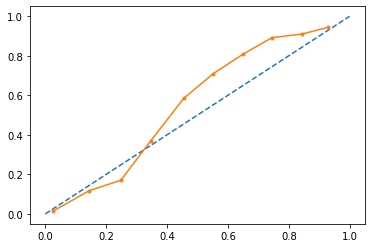

In [127]:
from sklearn.calibration import CalibratedClassifierCV
from sklearn.model_selection import train_test_split
from sklearn.calibration import calibration_curve
from matplotlib import pyplot
# reliability diagram for CV30 which has pretty good predicitons
fop, mpv = calibration_curve(y_test[:, 2], predictprobs[:, 2], n_bins=10)
# plot perfectly calibrated
pyplot.plot([0, 1], [0, 1], linestyle='--')
# plot model reliability
pyplot.plot(mpv, fop, marker='.')
pyplot.show()

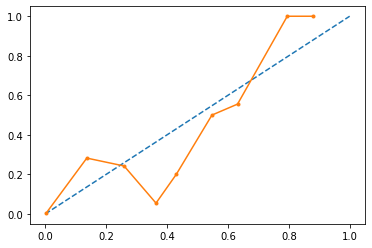

In [128]:
# reliability diagram for CV20 which has worse predictions
fop, mpv = calibration_curve(y_test[:, 0], predictprobs[:, 0], n_bins=10)
# plot perfectly calibrated
pyplot.plot([0, 1], [0, 1], linestyle='--')
# plot model reliability
pyplot.plot(mpv, fop, marker='.')
pyplot.show()

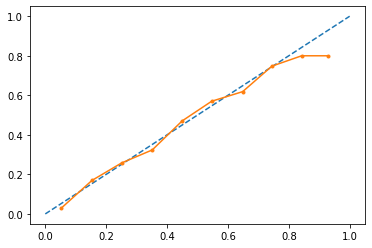

In [129]:
# reliability diagram for CV50 which has worst ROCAUC
fop, mpv = calibration_curve(y_test[:, 6], predictprobs[:, 6], n_bins=10)
# plot perfectly calibrated
pyplot.plot([0, 1], [0, 1], linestyle='--')
# plot model reliability
pyplot.plot(mpv, fop, marker='.')
pyplot.show()

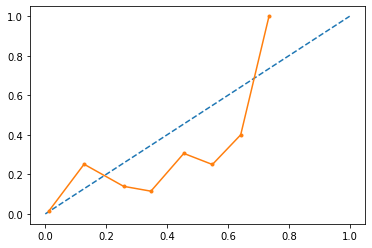

In [130]:
# reliability diagram for CV90 which has bad recall like 20
fop, mpv = calibration_curve(y_test[:, 14], predictprobs[:, 14], n_bins=10)
# plot perfectly calibrated
pyplot.plot([0, 1], [0, 1], linestyle='--')
# plot model reliability
pyplot.plot(mpv, fop, marker='.')
pyplot.show()

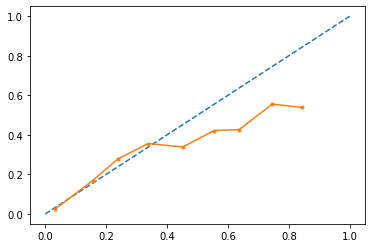

In [131]:
# reliability diagram for CV65 which should be an underestimate, so above the diagonal
fop, mpv = calibration_curve(y_test[:, 9], predictprobs[:, 9], n_bins=10)
# plot perfectly calibrated
pyplot.plot([0, 1], [0, 1], linestyle='--')
# plot model reliability
pyplot.plot(mpv, fop, marker='.')
pyplot.show()

In [135]:
#Single label training for just CV20
forest_20 = RandomForestClassifier(n_estimators=200, random_state=23)
forest_20.fit(X_train[:, 1:], y_train[:, 0])

predict20 = forest_20.predict(X_test[:, 1:])
predprob20 = forest_20.predict_proba(X_test[:, 1:])

print('Precision: ', precision_score(y_test[:, 0], predict20))
print('Recall: ', recall_score(y_test[:, 0], predict20))
print('ROC AUC: ', roc_auc_score(y_test[:, 0], predprob20[:, 1]))
print('Predict Count: ', np.sum(predict20, axis = 0))
print('Real Count: ', np.sum(y_test[:, 0], axis = 0))


Precision:  0.5652173913043478
Recall:  0.05963302752293578
ROC AUC:  0.9655609616363572
Predict Count:  23
Real Count:  218


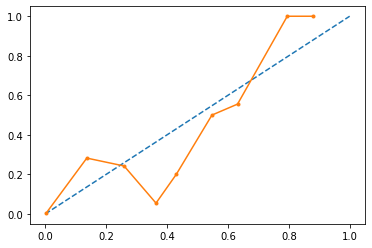

In [136]:
# reliability diagram for CV20 which has worse predictions
fop, mpv = calibration_curve(y_test[:, 0], predprob20[:, 1], n_bins=10)
# plot perfectly calibrated
pyplot.plot([0, 1], [0, 1], linestyle='--')
# plot model reliability
pyplot.plot(mpv, fop, marker='.')
pyplot.show()

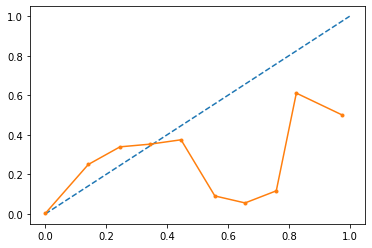

In [137]:
#Feed the model into calibration classifier which makes new model
calibrated = CalibratedClassifierCV(forest_20, method='sigmoid', cv=5)
#Fitting that new model
calibrated.fit(X_train[:, 1:], y_train[:, 0])
# predict probabilities
probs = calibrated.predict_proba(X_test[:, 1:])[:, 1]
# reliability diagram
fop, mpv = calibration_curve(y_test[:, 0], probs, n_bins=10, normalize=True)
# plot perfectly calibrated
pyplot.plot([0, 1], [0, 1], linestyle='--')
# plot calibrated reliability
pyplot.plot(mpv, fop, marker='.')
pyplot.show()